In [13]:
# Reorders Gadget snapshots into sorted HDF5 file

import numpy as np
import h5py
import math
import time,sys,os
import datetime
import readsnap
from mpi4py import MPI
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
#define particle datatype
vect = np.dtype([('x', np.float32),('y', np.float32),('z', np.float32)])
part = np.dtype([('ID', np.ulonglong),('pos', vect),('vel', vect)])

In [3]:
snap = 62
#snapshot_fname = '/cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_{0:03d}/Planck2013-L750-N512-Fiducial_{0:03d}.0'.format(snap)
snapshot_fname =  '/cosma6/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_2048_Box_3000-Fiducial/run1/snapdir_{0:03d}/Planck2013-L3000-N2048-Fiducial_{0:03d}.0'.format(snap)
 
head = readsnap.snapshot_header(snapshot_fname)

# read relevant paramaters on the snapshot
Npart    = head.npart
BoxSize  = head.boxsize/1e3 #Mpc/h
Masses   = head.massarr*1e10 #Msun/h
Nall     = head.nall  
filenum  = head.filenum
Omega_m  = head.omega_m
Omega_l  = head.omega_l
redshift = head.redshift
fformat  = head.format
Hubble   = head.hubble
Nall_hi  = head.nall_hi

In [4]:
print(Npart)
print(Nall)
print(filenum)
print(fformat)
print('Number of particles = {0:d}'.format(Nall_hi[1]* 2**32 + Nall[1]))

[      0 2084113       0       0       0       0]
[0 0 0 0 0 0]
4096
1
Number of particles = 8589934592


In [28]:
Nparts_tot = 0
max_id = 0
min_id = 100000
id =np.empty(0, dtype=np.uint64)

In [29]:

for sub in range(filenum):
    snapshot_fname =  '/cosma6/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_2048_Box_3000-Fiducial/run1/snapdir_{0:03d}/Planck2013-L3000-N2048-Fiducial_{0:03d}.{1:d}'.format(snap, sub)
    head = readsnap.snapshot_header(snapshot_fname)
    Npart = head.npart[1]
    Nparts_tot += Npart
    # read particle IDs
    ids = readsnap.read_block(snapshot_fname, "ID  ", 1)
    id_max = np.amax(ids)
    id_min = np.amin(ids)
    if (id_max>max_id): max_id = id_max
    if (id_min<min_id): min_id = id_min
    if (sub%100 == 0): print('Sub = {0:d}, max ID = {1:d}, min ID = {2:d}, tot parts = {3:d}'.format(sub, max_id, min_id, Nparts_tot))
        
print('Finished, total parts = {0:d}'.format(Nparts_tot))

Sub = 0, max ID = 8363077852, min ID = 100000, tot parts = 2100367
Sub = 100, max ID = 8589934175, min ID = 454, tot parts = 212004282
Sub = 200, max ID = 8589934175, min ID = 454, tot parts = 421789046
Sub = 300, max ID = 8589934175, min ID = 7, tot parts = 631518988
Sub = 400, max ID = 8589934175, min ID = 7, tot parts = 841314038
Sub = 500, max ID = 8589934505, min ID = 7, tot parts = 1051146238
Sub = 600, max ID = 8589934528, min ID = 7, tot parts = 1260922382
Sub = 700, max ID = 8589934528, min ID = 7, tot parts = 1470667103
Sub = 800, max ID = 8589934528, min ID = 7, tot parts = 1680386772
Sub = 900, max ID = 8589934528, min ID = 7, tot parts = 1890131975
Sub = 1000, max ID = 8589934528, min ID = 7, tot parts = 2099918111
Sub = 1100, max ID = 8589934528, min ID = 7, tot parts = 2309739442
Sub = 1200, max ID = 8589934528, min ID = 7, tot parts = 2519473490
Sub = 1300, max ID = 8589934528, min ID = 7, tot parts = 2729290717
Sub = 1400, max ID = 8589934528, min ID = 7, tot parts = 2

In [7]:
type(ids[0])

numpy.uint64

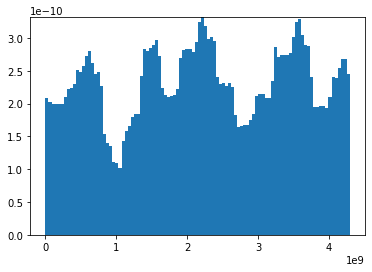

In [13]:
plt.hist(id , density=True, log=False, bins=100)
plt.show()

In [9]:
c = Counter(id)

In [ ]:
i

In [105]:
verbose = False
DEBUG = 2

In [94]:
# do a loop over all files
ptype = 1 #dark matter
chunks = 16
fcount = filenum//chunks
chunk = 2
snap = 62
start_file = chunk * fcount
end_file = start_file + fcount

#input file 
#snapshot_fname = '/cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_{0:03d}/Planck2013-L750-N512-Fiducial_{0:03d}'.format(snap)
snapshot_fname =  '/cosma6/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_2048_Box_3000-Fiducial/run1/snapdir_{0:03d}/Planck2013-L3000-N2048-Fiducial_{0:03d}'.format(snap)

# write galaxy data for each redshift bin into its own file
output_path = '/cosma6/data/dp004/dc-boot5/Ordered_Snapshots/'
ordered_snap = output_path + 'ordered_snapshot_L3000.snap__new_{0:03d}.hdf5'.format(snap)

# create structured array to hold all particles
Nparts = Nall_hi[1]* 2**32 + Nall[1]+1
pts = np.zeros(Nparts, dtype = part)

for i in range(start_file, end_file):     
    # find the name of the sub-snapshot
    if filenum==1:       snapshot = snapshot_fname
    else:                snapshot = snapshot_fname + '.{0:d}'.format(i)

    # find the local particles in the sub-snapshot
    head  = readsnap.snapshot_header(snapshot)
    npart = head.npart

    if verbose:  print ('Sub-snapshot {0:d}, DM particles = {1:d} \n'.format(i, npart[ptype]))
    if (DEBUG>1 and i%100 == 0):  print ('Sub-snapshot {0:d}, DM particles = {1:d}, time = {2:%H:%M:%S}'.format(i, npart[ptype], datetime.datetime.now()))

    p = np.empty(npart[ptype], dtype=part)
    
    # read particle IDs
    ids = readsnap.read_block(snapshot, "ID  ", ptype)

    # read positions in Mpc/h
    pos = readsnap.read_block(snapshot, "POS ", ptype)

    # read velocities in km/s 
    vel = readsnap.read_block(snapshot, "VEL ", ptype)

    # Assign particle parameters to particle array in ID order
    pts['ID'][ids] = ids
    pts['pos']['x'][ids] = pos[::,0]
    pts['pos']['y'][ids] = pos[::,1]
    pts['pos']['z'][ids] = pos[::,2]
    pts['vel']['x'][ids] = vel[::,0]
    pts['vel']['y'][ids] = vel[::,1]
    pts['vel']['z'][ids] = vel[::,2]
    
if (DEBUG>1):  print ('Finished reading unordered files, time = {0:%H:%M:%S}'.format(datetime.datetime.now()))


Sub-snapshot 600, DM particles = 2088392, time = 13:59:15
Sub-snapshot 700, DM particles = 2106131, time = 14:03:08
Finished reading unordered files, time = 14:05:55


In [100]:
pts['ID'][pts['ID']>0]

array([        63,         64,         65, ..., 4294967237, 4294967238,
       4294967239], dtype=uint64)

In [101]:
print(Nparts)

8589934593


In [ ]:

with h5py.File(ordered_snap,'a') as fo:
    # create new dataset to hold all particles
    if (chunk==0):
        parts= fo.create_dataset('Particles', data = pts, chunks = True)
    else:
        parts= fo['Particles']
         # merge new particles from this chunk into this dataset
        nblocks = 32
        for k in range(nblocks):
            print('Merging block {0:01d}, time = {1:%H:%M:%S}'.format(k,datetime.datetime.now()))
            parts_per_block  = Nparts//nblocks
            first_part = parts_per_block * k
            last_part = first_part + parts_per_block           
            parts[first_part:last_part] = np.where(pts['ID'][first_part:last_part]>0,pts[first_part:last_part],parts[first_part:last_part]) 
    if (DEBUG>1):  print ('Finished merging new particles to dataset, time = {0:%H:%M:%S}'.format(datetime.datetime.now()))

In [16]:
snap = 63
output_path = '/cosma6/data/dp004/dc-boot5/Ordered_Snapshots/'
ordered_snap = output_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [25]:
ordered_snap

'/cosma6/data/dp004/dc-boot5/Ordered_Snapshots/ordered_snapshot_L3000.snap__new_062.hdf5'

In [ ]:
p = np.zeros(Nall_hi[1]* 2**32 + Nall[1]+1, dtype = part)

with h5py.File(ordered_snap,'r') as fi:
    d0 = fi['Chunk_00']
    d1 = fi['Chunk_01']
    p = d0 | d1

In [ ]:
p[:100]

In [26]:
pts.shape

(8589934593,)

In [13]:
Lbox = 750
chi_max = 290
Nparts = 134217728
Nparts * 4/3*np.pi * chi_max**3 / Lbox**3

32501895.958082717

In [13]:
100663297 + 33554432

134217729

In [16]:
Nparts/32

4194304.0

In [17]:
38582480 * 48

1851959040

In [24]:
i +=1 
i = i%2
print(i)

1


In [32]:
(4**3)*2 /60

2.1333333333333333

In [14]:
Nparts/8

16777216.0

In [15]:
2**31

2147483648

In [2]:
a = np.zeros(10, dtype = int)
b = np.arange(10)

In [4]:
print(b)

[0 1 2 3 4 5 6 7 8 9]


In [5]:
np.where(b>5, b, a)

array([0, 0, 0, 0, 0, 0, 6, 7, 8, 9])

In [6]:
a = np.zeros(10, dtype = int)
with h5py.File('test', 'w') as f:
    f.create_dataset('numbs', data = a)

In [12]:
b = np.arange(10)
with h5py.File('test', 'a') as f:
    d  = f['numbs']
    d[::] = np.where(b>5,b,d)
    print(d[::])

[0 0 0 0 0 0 6 7 8 9]


In [13]:
with h5py.File('test', 'r') as f:
    d  = f['numbs']
    print(d[::])

[0 0 0 0 0 0 6 7 8 9]


In [29]:
4659429408 / 134217728

34.71545433998108

In [22]:
4908 * 56

274848

In [24]:
snap = 60
sub = 0
fname = '/cosma7/data/dp004/dc-boot5/Ordered_Snapshots/Npart_2048_Box_3000-Fiducial/snapdir_{0:02d}/ordered_snapshot.snap_{0:03d}.{1:02d}.hdf5'.format(snap,sub)

In [25]:

with h5py.File(fname, 'r') as f:
    d  = f['Parts']
    #print(d['ID'][:10:])
    #print(d['ID'][-10::])
    print(d.size)
    #print(f.keys())
    pts =np.empty(f['Parts'].shape, dtype=part)
    f['Parts'].read_direct(pts)  

153391689


In [26]:
pts['ID'][:100:]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=uint64)

In [27]:
pts['pos']['x'][:10]

array([0.       , 6.8892884, 6.932551 , 6.9081573, 6.347544 , 6.6823335,
       6.0644145, 5.5351205, 5.0106874, 5.5494833], dtype=float32)

In [78]:
ids = pts['ID']

In [79]:
Nparts = pts.size//2
block = 1

In [80]:
f = tuple([(ids > block * Nparts) & (ids <= (block+1) * Nparts)])
i = ids[f] - (block * Nparts)
ids2 = pts['ID'][f]

In [14]:
2**32

4294967296

In [82]:
4294967296

array([       1,        2,        3, ..., 76695842, 76695843, 76695844],
      dtype=uint64)

In [20]:
2**33

8589934592